# Cirq introduction tutorials - [part 1](https://www.tensorflow.org/quantum/tutorials/hello_many_worlds)

In [1]:
!pip install tensorflow==2.4.1

In [2]:
!pip install tensorflow-quantum

In [3]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [4]:
a, b = sympy.symbols('a b')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


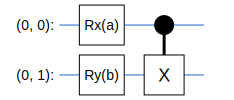

In [5]:
# Create two qubits
q0, q1 = cirq.GridQubit.rect(1, 2)

# Create a circuit on these qubits using the parameters you created above.
circuit = cirq.Circuit(
    cirq.rx(a).on(q0),
    cirq.ry(b).on(q1), cirq.CNOT(control=q0, target=q1))

SVGCircuit(circuit)

In [6]:
# Calculate a state vector with a=0.5 and b=-0.5.
resolver = cirq.ParamResolver({a: 0.5, b: -0.5})
output_state_vector = cirq.Simulator().simulate(circuit, resolver).final_state_vector
output_state_vector

array([ 0.9387913 +0.j        , -0.23971277+0.j        ,
        0.        +0.06120872j,  0.        -0.23971277j], dtype=complex64)

In [7]:
z0 = cirq.Z(q0)

qubit_map={q0: 0, q1: 1}

z0.expectation_from_state_vector(output_state_vector, qubit_map).real


0.8775825500488281

In [8]:
z0x1 = 0.5 * z0 + cirq.X(q1)

z0x1.expectation_from_state_vector(output_state_vector, qubit_map).real

-0.04063427448272705

In [9]:
# Rank 1 tensor containing 1 circuit.
circuit_tensor = tfq.convert_to_tensor([circuit])

print(circuit_tensor.shape)
print(circuit_tensor.dtype)

(1,)
<dtype: 'string'>


In [10]:
# Rank 1 tensor containing 2 Pauli operators.
pauli_tensor = tfq.convert_to_tensor([z0, z0x1])
pauli_tensor.shape

TensorShape([2])

In [11]:
batch_vals = np.array(np.random.uniform(0, 2 * np.pi, (5, 2)), dtype=np.float32)

In [12]:
cirq_results = []
cirq_simulator = cirq.Simulator()

for vals in batch_vals:
    resolver = cirq.ParamResolver({a: vals[0], b: vals[1]})
    final_state_vector = cirq_simulator.simulate(circuit, resolver).final_state_vector
    cirq_results.append(
        [z0.expectation_from_state_vector(final_state_vector, {
            q0: 0,
            q1: 1
        }).real])

print('cirq batch results: \n {}'.format(np.array(cirq_results)))

cirq batch results: 
 [[ 0.21694347]
 [-0.99640793]
 [-0.10101223]
 [ 0.99991703]
 [-0.94504678]]


In [13]:
tfq.layers.Expectation()(circuit,
                         symbol_names=[a, b],
                         symbol_values=batch_vals,
                         operators=z0)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[ 0.21694529],
       [-0.9964079 ],
       [-0.10101259],
       [ 0.9999171 ],
       [-0.9450465 ]], dtype=float32)>

## Control circuit definition

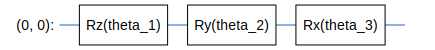

In [14]:
# Parameters that the classical NN will feed values into.
control_params = sympy.symbols('theta_1 theta_2 theta_3')

# Create the parameterized circuit.
qubit = cirq.GridQubit(0, 0)
model_circuit = cirq.Circuit(
    cirq.rz(control_params[0])(qubit),
    cirq.ry(control_params[1])(qubit),
    cirq.rx(control_params[2])(qubit))

SVGCircuit(model_circuit)

In [15]:
# The classical neural network layers.
controller = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='elu'),
    tf.keras.layers.Dense(3)
])

In [16]:
controller(tf.constant([[0.0],[1.0]])).numpy()

array([[ 0.        ,  0.        ,  0.        ],
       [-0.2066036 ,  0.27419376,  0.38624534]], dtype=float32)

In [17]:
# This input is the simulated miscalibration that the model will learn to correct.
circuits_input = tf.keras.Input(shape=(),
                                # The circuit-tensor has dtype `tf.string` 
                                dtype=tf.string,
                                name='circuits_input')

# Commands will be either `0` or `1`, specifying the state to set the qubit to.
commands_input = tf.keras.Input(shape=(1,),
                                dtype=tf.dtypes.float32,
                                name='commands_input')

In [18]:
dense_2 = controller(commands_input)

# TFQ layer for classically controlled circuits.
expectation_layer = tfq.layers.ControlledPQC(model_circuit,
                                             # Observe Z
                                             operators = cirq.Z(qubit))
expectation = expectation_layer([circuits_input, dense_2])

In [19]:
# The full Keras model is built from our layers.
model = tf.keras.Model(inputs=[circuits_input, commands_input],
                       outputs=expectation)

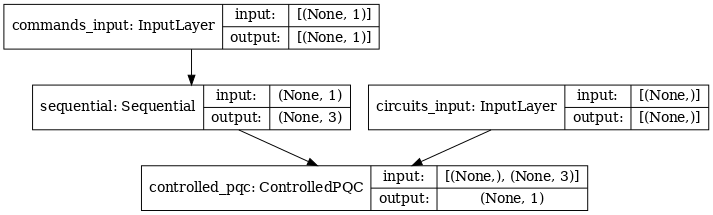

In [20]:
#https://stackoverflow.com/questions/47605558/importerror-failed-to-import-pydot-you-must-install-pydot-and-graphviz-for-py
!pip install pydot
!pip install pydotplus
!pip install graphviz
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

In [21]:
# The command input values to the classical NN.
commands = np.array([[0], [1]], dtype=np.float32)

# The desired Z expectation value at output of quantum circuit.
expected_outputs = np.array([[1], [-1]], dtype=np.float32)

In [22]:
random_rotations = np.random.uniform(0, 2 * np.pi, 3)
noisy_preparation = cirq.Circuit(
  cirq.rx(random_rotations[0])(qubit),
  cirq.ry(random_rotations[1])(qubit),
  cirq.rz(random_rotations[2])(qubit)
)
datapoint_circuits = tfq.convert_to_tensor([
  noisy_preparation
] * 2)  # Make two copied of this circuit

In [23]:
datapoint_circuits.shape

TensorShape([2])

In [24]:
model([datapoint_circuits, commands]).numpy()

array([[-0.13776001],
       [-0.41155192]], dtype=float32)

In [25]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)
history = model.fit(x=[datapoint_circuits, commands],
                    y=expected_outputs,
                    epochs=30,
                    verbose=0)

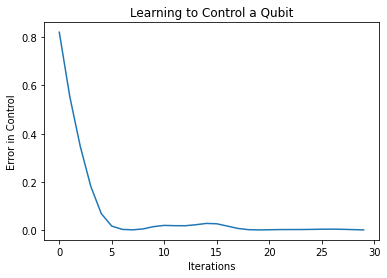

In [26]:
plt.plot(history.history['loss'])
plt.title("Learning to Control a Qubit")
plt.xlabel("Iterations")
plt.ylabel("Error in Control")
plt.show()

In [27]:
def check_error(command_values, desired_values):
  """Based on the value in `command_value` see how well you could prepare
  the full circuit to have `desired_value` when taking expectation w.r.t. Z."""
  params_to_prepare_output = controller(command_values).numpy()
  full_circuit = noisy_preparation + model_circuit

  # Test how well you can prepare a state to get expectation the expectation
  # value in `desired_values`
  for index in [0, 1]:
    state = cirq_simulator.simulate(
        full_circuit,
        {s:v for (s,v) in zip(control_params, params_to_prepare_output[index])}
    ).final_state_vector
    expt = cirq.Z(qubit).expectation_from_state_vector(state, {qubit: 0}).real
    print(f'For a desired output (expectation) of {desired_values[index]} with'
          f' noisy preparation, the controller\nnetwork found the following '
          f'values for theta: {params_to_prepare_output[index]}\nWhich gives an'
          f' actual expectation of: {expt}\n')


check_error(commands, expected_outputs)

For a desired output (expectation) of [1.] with noisy preparation, the controller
network found the following values for theta: [ 0.11867148 -1.5644112  -0.00191106]
Which gives an actual expectation of: 0.9668033719062805

For a desired output (expectation) of [-1.] with noisy preparation, the controller
network found the following values for theta: [-2.2020602  2.0926158  2.28853  ]
Which gives an actual expectation of: -0.975149393081665



In [28]:
model([datapoint_circuits, commands])

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[ 0.96680325],
       [-0.9751492 ]], dtype=float32)>

## Learning to prepare eigenstates of different operators

In [29]:
# Define inputs.
commands_input = tf.keras.layers.Input(shape=(1),
                                       dtype=tf.dtypes.float32,
                                       name='commands_input')
circuits_input = tf.keras.Input(shape=(),
                                # The circuit-tensor has dtype `tf.string` 
                                dtype=tf.dtypes.string,
                                name='circuits_input')
operators_input = tf.keras.Input(shape=(1,),
                                 dtype=tf.dtypes.string,
                                 name='operators_input')

In [30]:
# Define classical NN.
controller = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='elu'),
    tf.keras.layers.Dense(3)
])

In [31]:
dense_2 = controller(commands_input)

# Since you aren't using a PQC or ControlledPQC you must append
# your model circuit onto the datapoint circuit tensor manually.
full_circuit = tfq.layers.AddCircuit()(circuits_input, append=model_circuit)
expectation_output = tfq.layers.Expectation()(full_circuit,
                                              symbol_names=control_params,
                                              symbol_values=dense_2,
                                              operators=operators_input)

# Contruct your Keras model.
two_axis_control_model = tf.keras.Model(
    inputs=[circuits_input, commands_input, operators_input],
    outputs=[expectation_output])

In [32]:
# The operators to measure, for each command.
operator_data = tfq.convert_to_tensor([[cirq.X(qubit)], [cirq.Z(qubit)]])

# The command input values to the classical NN.
commands = np.array([[0], [1]], dtype=np.float32)

# The desired expectation value at output of quantum circuit.
expected_outputs = np.array([[1], [-1]], dtype=np.float32)

In [34]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
loss = tf.keras.losses.MeanSquaredError()

two_axis_control_model.compile(optimizer=optimizer, loss=loss)

history = two_axis_control_model.fit(
    x=[datapoint_circuits, commands, operator_data],
    y=expected_outputs,
    epochs=30,
    validation_split=0.2,
    verbose=2)

Epoch 1/30
1/1 - 1s - loss: 1.1069e-04 - val_loss: 8.0502e-04
Epoch 2/30
1/1 - 0s - loss: 4.2308e-04 - val_loss: 1.9077e-04
Epoch 3/30
1/1 - 0s - loss: 1.1948e-06 - val_loss: 5.8937e-05
Epoch 4/30
1/1 - 0s - loss: 7.2263e-06 - val_loss: 3.5041e-05
Epoch 5/30
1/1 - 0s - loss: 1.6359e-04 - val_loss: 2.7922e-05
Epoch 6/30
1/1 - 0s - loss: 1.1799e-04 - val_loss: 2.1361e-05
Epoch 7/30
1/1 - 0s - loss: 1.2826e-05 - val_loss: 1.7886e-05
Epoch 8/30
1/1 - 0s - loss: 7.4491e-08 - val_loss: 1.7473e-05
Epoch 9/30
1/1 - 0s - loss: 4.0417e-07 - val_loss: 2.0003e-05
Epoch 10/30
1/1 - 0s - loss: 1.1064e-05 - val_loss: 2.9844e-05
Epoch 11/30
1/1 - 0s - loss: 4.2747e-05 - val_loss: 6.7447e-05
Epoch 12/30
1/1 - 0s - loss: 5.5500e-05 - val_loss: 1.8126e-04
Epoch 13/30
1/1 - 0s - loss: 3.0733e-05 - val_loss: 4.3728e-04
Epoch 14/30
1/1 - 0s - loss: 8.5419e-06 - val_loss: 8.7932e-04
Epoch 15/30
1/1 - 0s - loss: 1.1302e-06 - val_loss: 0.0015
Epoch 16/30
1/1 - 0s - loss: 3.5972e-08 - val_loss: 0.0023
Epoch 17/

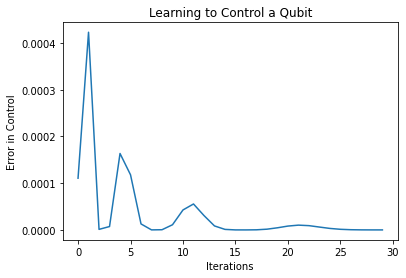

In [35]:
plt.plot(history.history['loss'])
plt.title("Learning to Control a Qubit")
plt.xlabel("Iterations")
plt.ylabel("Error in Control")
plt.show()

In [36]:
controller.predict(np.array([0,1]))

array([[-0.10500949, -0.1273543 , -0.2786051 ],
       [-0.00851865,  0.98665285, -0.3910666 ]], dtype=float32)

## Model 2

In [41]:
# Define inputs.
commands_input = tf.keras.layers.Input(shape=(1),
                                       dtype=tf.dtypes.float32,
                                       name='commands_input')
circuits_input = tf.keras.Input(shape=(),
                                # The circuit-tensor has dtype `tf.string` 
                                dtype=tf.dtypes.string,
                                name='circuits_input')
operators_input = tf.keras.Input(shape=(1,),
                                 dtype=tf.dtypes.string,
                                 name='operators_input')

# Define classical NN.
controller = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(2000, activation='relu'),
    tf.keras.layers.Dense(3)
])

dense_2 = controller(commands_input)

# Since you aren't using a PQC or ControlledPQC you must append
# your model circuit onto the datapoint circuit tensor manually.
full_circuit = tfq.layers.AddCircuit()(circuits_input, append=model_circuit)
expectation_output = tfq.layers.Expectation()(full_circuit,
                                              symbol_names=control_params,
                                              symbol_values=dense_2,
                                              operators=operators_input)

# Contruct your Keras model.
two_axis_control_model = tf.keras.Model(
    inputs=[circuits_input, commands_input, operators_input],
    outputs=[expectation_output])

# The operators to measure, for each command.
operator_data = tfq.convert_to_tensor([[cirq.X(qubit)], [cirq.Z(qubit)]])

# The command input values to the classical NN.
commands = np.array([[0], [1]], dtype=np.float32)

# The desired expectation value at output of quantum circuit.
expected_outputs = np.array([[1], [-1]], dtype=np.float32)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
loss = tf.keras.losses.MeanSquaredError()

two_axis_control_model.compile(optimizer=optimizer, loss=loss)

history = two_axis_control_model.fit(
    x=[datapoint_circuits, commands, operator_data],
    y=expected_outputs,
    epochs=30,
    validation_split=0.2,
    verbose=2)

Epoch 1/30
1/1 - 1s - loss: 1.9399e-04 - val_loss: 0.8768
Epoch 2/30
1/1 - 0s - loss: 2.3625e-05 - val_loss: 0.9556
Epoch 3/30
1/1 - 0s - loss: 1.2989e-06 - val_loss: 1.0207
Epoch 4/30
1/1 - 0s - loss: 1.7859e-07 - val_loss: 1.0757
Epoch 5/30
1/1 - 0s - loss: 1.6259e-06 - val_loss: 1.1226
Epoch 6/30
1/1 - 0s - loss: 8.4481e-06 - val_loss: 1.1609
Epoch 7/30
1/1 - 0s - loss: 2.1183e-05 - val_loss: 1.1879
Epoch 8/30
1/1 - 0s - loss: 3.1892e-05 - val_loss: 1.2018
Epoch 9/30
1/1 - 0s - loss: 3.2485e-05 - val_loss: 1.2037
Epoch 10/30
1/1 - 0s - loss: 2.4426e-05 - val_loss: 1.1963
Epoch 11/30
1/1 - 0s - loss: 1.4469e-05 - val_loss: 1.1831
Epoch 12/30
1/1 - 0s - loss: 7.1279e-06 - val_loss: 1.1670
Epoch 13/30
1/1 - 0s - loss: 3.1041e-06 - val_loss: 1.1501
Epoch 14/30
1/1 - 0s - loss: 1.3216e-06 - val_loss: 1.1335
Epoch 15/30
1/1 - 0s - loss: 6.6652e-07 - val_loss: 1.1177
Epoch 16/30
1/1 - 0s - loss: 5.0632e-07 - val_loss: 1.1028
Epoch 17/30
1/1 - 0s - loss: 6.0856e-07 - val_loss: 1.0890
Epoch 

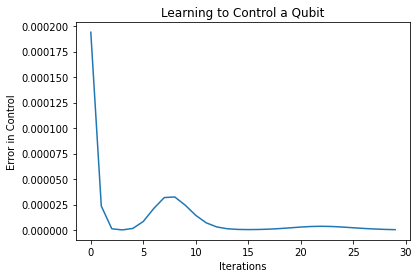

array([[-0.07127561, -0.11574811, -0.00866337],
       [-0.04678178, -0.14110886, -0.01753507]], dtype=float32)

In [43]:
plt.plot(history.history['loss'])
plt.title("Learning to Control a Qubit")
plt.xlabel("Iterations")
plt.ylabel("Error in Control")
plt.show()

controller.predict(np.array([0,1]))